In [1]:
# Importing the libraries
import os
import math
import datetime

from tqdm import tqdm 

import pandas as pd 
import numpy as np

import tensorflow as tf
from tensorflow import keras 

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer 

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from matplotlib import rc 

from sklearn.metrics import confusion_matrix, classification_report

sns.set(style='dark', palette='muted', font_scale=1.2)
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
FLATUI_PALETTE = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
# !pip install bert-for-tf2

# !gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output "data/train.csv"
# !gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output "data/valid.csv"
# !gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output "data/test.csv"


In [3]:
# Loading the data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
valid = pd.read_csv('./data/valid.csv')

train = train.append(valid).reset_index(drop=True)


In [4]:
display(train.head(3))
display('Train Shape is:', train.shape )

display(test.head(3))
display('Test Shape is:', test.shape)


,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook


'Train Shape is:'

(13784, 2)

,text,intent
0,add sabrina salerno to the grime instrumentals...,AddToPlaylist
1,i want to bring four people to a place that s ...,BookRestaurant
2,put lindsey cardinale into my hillary clinton ...,AddToPlaylist


'Test Shape is:'

(700, 2)

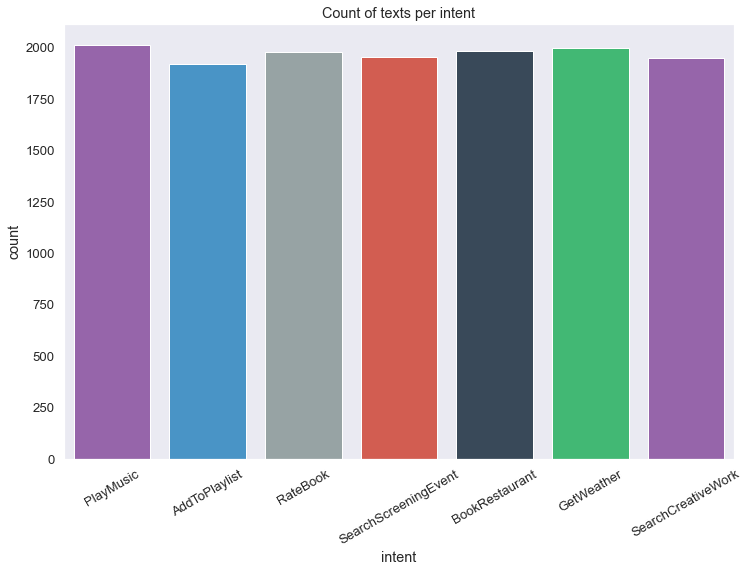

In [5]:
chart = sns.countplot(train.intent, palette=FLATUI_PALETTE)
plt.title('Count of texts per intent')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30);
plt.show()

# Intent Recognition 

In [6]:
# !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

# !mkdir model 
# !mv uncased_L-12_H-768_A-12.zip model 
# !unzip uncased_L-12_H-768_A-12.zip

In [7]:
bert_model_name = "uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join('model/', bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")



# Preprocessing using the BERT Tokenizer

In [8]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self,train,test, tokenizer: FullTokenizer, classes, max_seq_len=192 ):
        self.tokenizer = tokenizer
        self.max_seq_len = 0 
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y) ) = map(self._prepare, [train,test])


        self.max_seq_len = min(self.max_seq_len, max_seq_len)

        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])



    def _prepare(self,df):
        x,y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN] ,  row[IntentDetectionData.LABEL_COLUMN]

            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

            self.max_seq_len = max(self.max_seq_len, len(token_ids))


            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self,ids):
        x = []
        for input_ids in ids:
            cut_point = min(len(input_ids), self.max_seq_len - 2)
            input_ids = input_ids[:cut_point]
            # Adding padding 
            input_ids = input_ids + ( [0] * (self.max_seq_len - len(input_ids) )) 

            x.append(np.array(input_ids))
        return np.array(x)

In [9]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

tokens = tokenizer.tokenize("I can not wait to visit Pakistan again !")
tokens

['i', 'can', 'not', 'wait', 'to', 'visit', 'pakistan', 'again', '!']

In [10]:
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 2025, 3524, 2000, 3942, 4501, 2153, 999]

In [11]:
def create_model(max_seq_len,bert_config_file ,bert_ckpt_file):
    print("opening File")
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        print("Did this done that ")
    input_ids =keras.layers.Input(shape= (max_seq_len, ), dtype="int32", name="input_ids")
    bert_output = bert(input_ids)
    print(f"Bert shape: {bert_output.shape}")

    cls_out = keras.layers.Lambda(lambda seg : seg[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)

    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)

    out = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
    model = keras.Model(inputs=input_ids, outputs=logits)

    model.build(input_shape=(None,max_seq_len))


    load_stock_weights(bert, bert_ckpt_file)

    return model


In [12]:
##### 

classes = train.intent.unique().tolist()
print(classes)

['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent', 'BookRestaurant', 'GetWeather', 'SearchCreativeWork']


In [13]:
data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:07, 1830.30it/s]
700it [00:00, 1813.41it/s]


In [14]:
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

yerNorm/gamma] shape:(768,)
loader: Skipping weight:[bert/encoder/layer_8/attention/output/LayerNorm/beta:0] as the weight shape:[(36,)] is not compatible with the checkpoint:[bert/encoder/layer_8/attention/output/LayerNorm/beta] shape:(768,)
loader: Skipping weight:[bert/encoder/layer_8/intermediate/kernel:0] as the weight shape:[(36, 3072)] is not compatible with the checkpoint:[bert/encoder/layer_8/intermediate/dense/kernel] shape:(768, 3072)
loader: Skipping weight:[bert/encoder/layer_8/output/dense/kernel:0] as the weight shape:[(3072, 36)] is not compatible with the checkpoint:[bert/encoder/layer_8/output/dense/kernel] shape:(3072, 768)
loader: Skipping weight:[bert/encoder/layer_8/output/dense/bias:0] as the weight shape:[(36,)] is not compatible with the checkpoint:[bert/encoder/layer_8/output/dense/bias] shape:(768,)
loader: Skipping weight:[bert/encoder/layer_8/output/LayerNorm/gamma:0] as the weight shape:[(36,)] is not compatible with the checkpoint:[bert/encoder/layer_8/ou

In [15]:
print("Done")

Done


In [19]:
data.train_x.shape

(13784, 38)

In [22]:
data.train_y[1]

1